In [1]:
# %matplotlib qt

In [1]:
from Supplementary.loadVid import loadVid
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_H(correspondences):
    P = []
    for ((x1,y1),(x2,y2)) in correspondences[:4]:
        rows = [[x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2],
                [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]]
        P.extend(rows)

    _, __, V = np.linalg.svd(np.array(P))
    H = V[-1, :] / V[-1,-1]
    return H.reshape((3,3))

In [3]:
def find_H_cv(src, dst):
    h, _ = cv.findHomography(src, dst, cv.RANSAC, 5.0)
    return h

In [4]:
def find_correspondences_cv(img1, img2, plot=None):
    gray1 = cv.cvtColor(img1, cv.COLOR_RGB2GRAY)
    gray2 = cv.cvtColor(img2, cv.COLOR_RGB2GRAY)

    sift = cv.SIFT_create()

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    bf = cv.BFMatcher()

    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[g.queryIdx].pt for g in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[g.trainIdx].pt for g in good_matches]).reshape(-1,1,2)
    
    if plot is not None:
        if len(good_matches)>plot:
            to_plot = np.random.choice(good_matches, plot)
        else:
            to_plot = good_matches
        draw_params = dict(matchColor = (255,0,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)
        img3 = cv.drawMatches(img1, kp1, img2, kp2, to_plot, None, **draw_params)
        _ = plt.figure(figsize=(15,10))
        plt.imshow(img3)
        plt.show()
    
    return src_pts, dst_pts

In [5]:
def get_boundary(img, H):
    corner_points = [(0,0), (img.shape[1]-1,0), (0, img.shape[0]-1), (img.shape[1]-1, img.shape[0]-1)]
    new_corners = [[], []]
    for x,y in corner_points:
        point = np.array([x, y, 1])[:, np.newaxis]
        new_point = np.matmul(H, point).squeeze()
        xi, yi, _ = new_point/new_point[2]
        new_corners[0].append(xi)
        new_corners[1].append(yi)
    
    min_x, max_x = min(new_corners[0]), max(new_corners[0])
    min_y, max_y = min(new_corners[1]), max(new_corners[1])
    return (max_x, min_x), (max_y, min_y)

In [24]:
def gcd(a, b):
    if b==0:
        return a
    return gcd(b, a%b)

def get_aspect_ratio(size):
    gcd_ratio = gcd(size[1],size[0])
    return (size[1]/gcd_ratio, size[0]/gcd_ratio)

In [80]:
def crop_frame(frame, size):
    required_height, required_width = size
    if frame.shape[0]<required_height:
        aspect_ratio = get_aspect_ratio(size)
        required_width = frame.shape[0]*aspect_ratio[0]//aspect_ratio[1]
        required_height = frame.shape[0]
        print('alo')
    elif frame.shape[1]<required_width:
        aspect_ratio = get_aspect_ratio(size)
        required_height = frame.shape[1]*aspect_ratio[1]//aspect_ratio[0]
        required_width = frame.shape[1]
        print('alo2')
    center_x = frame.shape[1]//2
    center_y = frame.shape[0]//2
    start_x = int(max(center_x-(required_width//2), 0))
    end_x = int(min(center_x+(required_width//2), frame.shape[1]))
    start_y = int(max(center_y-(required_height//2), 0))
    end_y = int(min(center_y+(required_height//2), frame.shape[0]))
    cropped_frame = frame[start_y:end_y, start_x:end_x, :]
    # print(cropped_frame.shape)
    # cropped_frame = cv.resize(cropped_frame, size[::-1], interpolation=cv.INTER_AREA)
    return cropped_frame


In [7]:
video_original = loadVid('Supplementary/book.mov')
video_overlayed = loadVid('Supplementary/ar_source.mov')
book = cv.cvtColor(cv.imread('Supplementary/cv_cover.jpg'), cv.COLOR_BGR2RGB)

In [18]:
video_original.shape, video_overlayed.shape, book.shape

((641, 480, 640, 3), (511, 360, 640, 3), (440, 350, 3))

In [23]:
video_original.shape[1:3]

(480, 640)

In [25]:
get_aspect_ratio(video_original.shape[1:3])

(4.0, 3.0)

In [26]:
get_aspect_ratio(video_overlayed.shape[1:3])

(16.0, 9.0)

In [27]:
get_aspect_ratio(book.shape[:2])

(35.0, 44.0)

# TODO: Verify correct homography by displaying blue anc white points like last time

In [58]:
frame_original = video_original[0]
frame_overlay = video_overlayed[370]
frame_overlay = frame_overlay[44:316,:,:]

In [14]:
# h = find_H_cv(*find_correspondences_cv(book, frame_original, plot=50))
h = find_H_cv(*find_correspondences_cv(book, frame_original))

alo


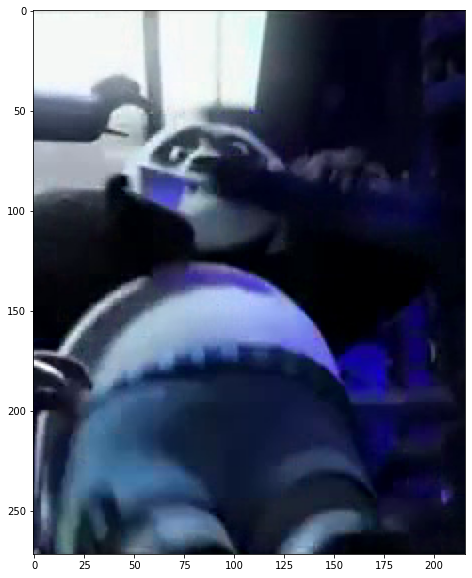

In [81]:
# (max_x, min_x), (max_y, min_y) = get_boundary(book, h)
# width = int(np.ceil(max_x)-np.floor(min_x))
# height = int(np.ceil(max_y)-np.floor(min_y))
height, width = book.shape[:2]
cropped_frame = crop_frame(frame_overlay, (height, width))
plt.figure(figsize=(15,10))
plt.imshow(cropped_frame)
plt.show()

In [82]:
cropped_frame.shape, (height,width)

((272, 216, 3), (440, 350))

In [85]:
get_aspect_ratio(cropped_frame.shape[:2]), get_aspect_ratio((height, width))

((27.0, 34.0), (35.0, 44.0))

In [ ]:
# TODO: figure out aspect ratio stuff. its not just take exact dimensions
# its probably more take a scale of the aspect ratio. Find aspect ratio of
# of book -> get similar aspect ratio from movie based on minimum dimension
# which is probably going to be y. if both dimensions are more than requried
# then just take exact dimensions of book. good night.